In [9]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
filepath2 = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors = json.load(open(filepath))
student_vectors2 = json.load(open(filepath2))

In [45]:
baseline = {}
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in baseline:
            baseline[j['task_id']] = 0
baseline

{'1zsCldT4p8.set1': 0,
 '1zsCldT4p8.set2': 0,
 '9wRCzK1G7F.partb': 0,
 'DebcfZEEmI.proper_fractions': 0,
 'Ok-iIHxjgx.parta': 0,
 'Ok-iIHxjgx.partb': 0,
 'hyei4uD81i.parta': 0,
 'kvig7fcCVc.partb': 0,
 'nl-M69Ez9k.parta': 0,
 'p7cfRPp-kQ.partb': 0}

In [46]:
num_right = {}
num_trials = {}
for i in baseline:
    number_of_trials = 0
    number_right = 0
    for j in student_vectors:
        for k in student_vectors[j]:
            if k['task_id'] == i and k['second_try'] == False:
                number_of_trials += 1
                if k['correct'] == True:
                    number_right += 1
    baseline[i] = number_right / number_of_trials
    num_trials[i] = number_of_trials
    num_right[i] = number_right
baseline

{'1zsCldT4p8.set1': 0.8358020800504254,
 '1zsCldT4p8.set2': 0.9005121837653267,
 '9wRCzK1G7F.partb': 0.8300663449939686,
 'DebcfZEEmI.proper_fractions': 0.807742496737712,
 'Ok-iIHxjgx.parta': 0.9011957205789805,
 'Ok-iIHxjgx.partb': 0.6627956989247312,
 'hyei4uD81i.parta': 0.545816733067729,
 'kvig7fcCVc.partb': 0.9438525770227469,
 'nl-M69Ez9k.parta': 0.8295813170629076,
 'p7cfRPp-kQ.partb': 0.8899297423887588}

In [47]:
import math
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def calculate_auc (y_true,y_pred,sequence_lengths=[],plot=False):
    if sequence_lengths == []:
        return roc_auc_score(y_true, y_pred)
    else:
        con_y_true = np.zeros([sum(sequence_lengths)])
        con_y_pred = np.zeros([sum(sequence_lengths)])
        index = 0
        for i in range(len(y_true)): #per student
            for j in range(sequence_lengths[i]): #up to the sequence length
                con_y_true[index] = y_true[i][j]
                if(plot):
                    con_y_pred[index] = y_pred[i][j]
                else:
                    con_y_pred[index] = y_pred[i][j]
                index += 1
        fpr, tpr, thresholds = roc_curve(con_y_true, con_y_pred)
        #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
        if(plot):
            return [roc_auc_score(con_y_true, con_y_pred),fpr,tpr]
        else:
            return roc_auc_score(con_y_true, con_y_pred)

def o_calculate_auc(true_all_tasks, predictions_all_tasks, sequence_lengths_all_tasks,plot=False):
    total = 0
    for i in sequence_lengths_all_tasks:
        total += sum(sequence_lengths_all_tasks[i])
    index = 0
    con_y_true = np.zeros([total])
    con_y_pred = np.zeros([total])
    for i in sequence_lengths_all_tasks: #per task ID
        for j in range(len(true_all_tasks[i])): #per student
            for k in range(sequence_lengths_all_tasks[i][j]): #up to sequence length
                con_y_true[index] = true_all_tasks[i][j][k]
                con_y_pred[index] = predictions_all_tasks[i][j][k]
                index += 1
    fpr, tpr, thresholds = roc_curve(con_y_true, con_y_pred)
    #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
    if(plot == True):
        return [roc_auc_score(con_y_true, con_y_pred),fpr,tpr]
    else:
        return roc_auc_score(con_y_true, con_y_pred)

In [48]:
print("with encoding of length 1")
np.set_printoptions(threshold=np.nan)

true_all_tasks = {}
true_all_tasks['train'] = {}
true_all_tasks['test'] = {}
predictions_all_tasks = {}
predictions_all_tasks['train'] = {}
predictions_all_tasks['test'] = {}
seqlen_all_tasks = {}
seqlen_all_tasks['train'] = {}
seqlen_all_tasks['test'] = {}

for i in baseline:
    #build y_true and y_scores
    len_vector = 1
    padding_experiment = 100.0
    sequences = []
    sequences_pred = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        interactions_pred = []
        interactions.append([padding_experiment]) #for getting the first prediction!
        interactions_pred.append([baseline[i]])
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.])
                    interactions_pred.append([baseline[i]])
                else:
                    interactions.append([0.])
                    interactions_pred.append([baseline[i]])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions)-1)
            sequences.append(interactions)
            sequences_pred.append(interactions_pred)
    
    #add padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths)+1,len_vector])
    padded_pred = np.zeros([len(sequences),max(sequences_lengths)+1,len_vector])
    padded_pred = padded_pred + padding_experiment
    padded_sequences = padded_sequences + padding_experiment
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]
            padded_pred[p][j] = sequences_pred[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_pred = padded_pred[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_pred = padded_pred[split:,1:]
    test_seqlen = sequences_lengths[split:]
    
    print(str(i) + " has %trials correct: " + str(baseline[i]*100))
    update_op_train = calculate_auc(train_y,train_pred,train_seqlen)
    update_op_test = calculate_auc(test_y,test_pred,test_seqlen)
    
    true_all_tasks['train'][i] = train_y
    true_all_tasks['test'][i] = test_y
    predictions_all_tasks['train'][i] = train_pred
    predictions_all_tasks['test'][i] = test_pred
    seqlen_all_tasks['train'][i] = train_seqlen
    seqlen_all_tasks['test'][i] = test_seqlen
    
    print("AUC train : {}".format(update_op_train))
    print("AUC test : {}".format(update_op_test))
    print("Number of trials who got it right: " + str(num_right[i]) + " out of " + str(num_trials[i]))        
    print("\n\n")

with encoding of length 1
p7cfRPp-kQ.partb has %trials correct: 88.99297423887587
AUC train : 0.5
AUC test : 0.5
Number of trials who got it right: 6460 out of 7259



Ok-iIHxjgx.partb has %trials correct: 66.27956989247312
AUC train : 0.5
AUC test : 0.5
Number of trials who got it right: 1541 out of 2325



1zsCldT4p8.set1 has %trials correct: 83.58020800504255
AUC train : 0.5
AUC test : 0.5
Number of trials who got it right: 5304 out of 6346



DebcfZEEmI.proper_fractions has %trials correct: 80.77424967377121
AUC train : 0.5
AUC test : 0.5
Number of trials who got it right: 5571 out of 6897



9wRCzK1G7F.partb has %trials correct: 83.00663449939685
AUC train : 0.5
AUC test : 0.5
Number of trials who got it right: 5505 out of 6632



1zsCldT4p8.set2 has %trials correct: 90.05121837653267
AUC train : 0.5
AUC test : 0.5
Number of trials who got it right: 5802 out of 6443



nl-M69Ez9k.parta has %trials correct: 82.95813170629076
AUC train : 0.5
AUC test : 0.5
Number of trials who got i

Overall Test AUC: 0.6163844419631744


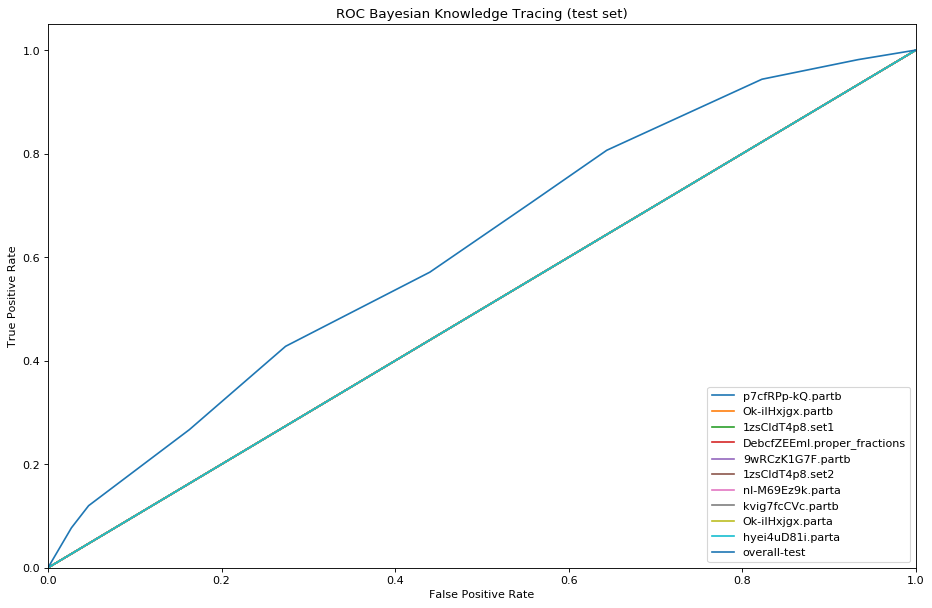

In [49]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (test set)')

for task_id in baseline:
    roc = calculate_auc(true_all_tasks['test'][task_id] , predictions_all_tasks['test'][task_id] , seqlen_all_tasks['test'][task_id],plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = o_calculate_auc(true_all_tasks['test'],predictions_all_tasks['test'],seqlen_all_tasks['test'],plot=True)
plt.plot(roc[1], roc[2], label='overall-test')
print("Overall Test AUC: "+str(roc[0]))
plt.legend(loc="lower right")

Overall Train AUC: 0.6419119786913078


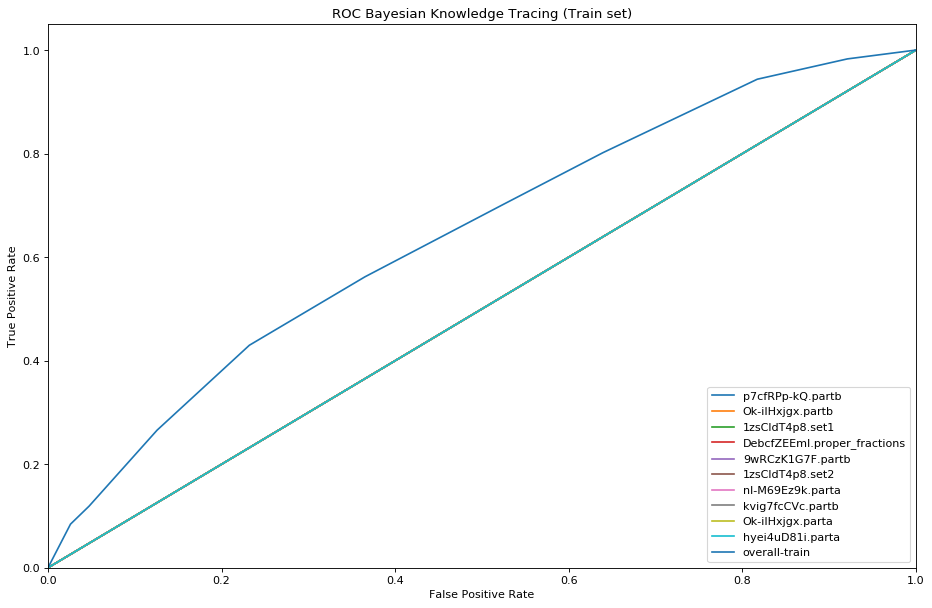

In [50]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (Train set)')

for task_id in baseline:
    roc = calculate_auc(true_all_tasks['train'][task_id],predictions_all_tasks['train'][task_id], seqlen_all_tasks['train'][task_id], plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = o_calculate_auc(true_all_tasks['train'],predictions_all_tasks['train'],seqlen_all_tasks['train'],plot=True)
plt.plot(roc[1], roc[2], label='overall-train')
print("Overall Train AUC: "+str(roc[0]))
plt.legend(loc="lower right")

In [7]:
# experimenting with different encodings, but results were the same as 0.5
# for i in baseline:
#     #build y_true and y_scores
#     len_vector = 1
#     sequences = []
#     sequences_pred = []
#     sequences_lengths = []
#     padding_experiment = 100.0
#     for p in student_vectors:
#         interactions = []
#         interactions_pred = []
#         interactions.append([padding_experiment]) #for getting the first prediction!
#         interactions_pred.append([baseline[i]])
#         for j in student_vectors[p]:
#             if(j['task_id'] == i and j['second_try'] == False):
#                 if(j['correct'] == True):
#                     interactions.append([1.])
#                     interactions_pred.append([baseline[i]])
#                 else:
#                     interactions.append([0.])
#                     interactions_pred.append([1 - baseline[i]])
#         if(len(interactions) > 1):
#             sequences_lengths.append(len(interactions)-1)
#             sequences.append(interactions)
#             sequences_pred.append(interactions_pred)
    
#     #add padding
#     padded_sequences = np.zeros([len(sequences),max(sequences_lengths)+1,len_vector])
#     padded_sequences = padded_sequences + padding_experiment
#     padded_pred = np.zeros([len(sequences),max(sequences_lengths)+1,len_vector])
#     padded_pred = padded_pred + padding_experiment
#     for p in range(len(sequences)):
#         for j in range(len(sequences[p])):
#             padded_sequences[p][j] = sequences[p][j]
#             padded_pred[p][j] = sequences_pred[p][j]

#     #split the train and test set like BKT
#     split = int(0.8*len(sequences))
#     train_x = padded_sequences[:split,:-1]
#     train_y = padded_sequences[:split,1:]
#     train_pred = padded_pred[:split,1:]
#     train_seqlen = sequences_lengths[:split]
#     test_x = padded_sequences[split:,:-1]
#     test_y = padded_sequences[split:,1:]
#     test_pred = padded_pred[split:,1:]
#     test_seqlen = sequences_lengths[split:]

#     print(str(i) + " has %trials correct: " + str(baseline[i]*100))
#     update_op_train = calculate_auc(train_y,train_pred,train_seqlen,len_vector=len_vector)
#     update_op_test = calculate_auc(test_y,test_pred,test_seqlen,len_vector=len_vector)
#     print("tf auc TRAIN : {}".format(update_op_train))
#     print("tf auc TEST : {}".format(update_op_test))
#     print("Number of trials who got it right: " + str(num_right[i]) + " out of " + str(num_trials[i]))        
#     print("\n\n")